# Simulations for the Gap statistic
---
We're going to start by defining a function which, given a matrix $X$ containing the points we are interested in clustering, gives a sample from the reference distribution associated to $X$.

In [1]:
reference_sample = function(points_matrix, sample_size, method = "svd") {
    if(method == "svd") {
        return(reference_SVD_sample(points_matrix, sample_size))
    } else if(method == "simple") {
        return(reference_simple_sample(points_matrix, sample_size))
    } else {
        stop("Not valid method for reference sampling!")
    }
}

reference_simple_sample = function(points_matrix, sample_size) {
    mins = c()
    maxs = c()
    for (column in 1 : ncol(points_matrix)) {
        mins = c(mins, min(points_matrix[, column]))
        maxs = c(maxs, max(points_matrix[, column]))
    }
    samples = c()
    for (column in 1 : ncol(points_matrix)) {
        samples = c(samples, runif(sample_size, min = mins[column], max = maxs[column]))
    }
    return(matrix(samples, ncol = ncol(points_matrix), byrow = FALSE))
}

reference_SVD_sample = function(points_matrix, sample_size) {
    means = c()
    for (column in 1 : ncol(points_matrix)) {
        means = c(means, mean(points_matrix[, column]))
    }
    centered_matrix = points_matrix - means
    V = svd(centered_matrix)$v
    sample = reference_simple_sample(centered_matrix %*% V, sample_size)
    sample = sample %*% t(V)
    return(sample + means)
}

We now define a function which, given a set of points, computes the gap statistic for that set under the kmean clustering algorithm.

In [84]:
compute_gap_statistic = function(data, k, B, method = "svd", with_se = FALSE) {
    standard_data = scale(data)
    clustering = kmeans(data, k, iter.max = 25)
    log_WK = log(clustering$tot.withinss)
    rows = nrow(data)
    reference_sample_data = reference_sample(data, B * rows, method)
    log_WKStar = c()
    for (instance in 1 : B) {
        first = 1 + rows * (instance - 1)
        last = rows * instance
        clustering = kmeans(reference_sample_data[first : last, ], k, iter.max = 25)
        log_WKStar = c(log_WKStar, log(clustering$tot.withinss))
    }
    if(with_se) {
        se = sd(log_WKStar) * sqrt(1 + (1 / B))
        return(c(mean(log_WKStar) - log_WK, se))
    }
    return(mean(log_WKStar) - log_WK)
}

In [3]:
find_best_k = function(data, B, method = "svd") {
    gap = -1
    k = 0
    gap_k_plus = compute_gap_statistic(data, k + 1, B, method)
    while(gap < 0) {
        k = k + 1
        gap_k = gap_k_plus
        k_plus = compute_gap_statistic(data, k + 1, B, method, TRUE)
        gap_k_plus = k_plus[1]
        se_k_plus = k_plus[2]
        gap = gap_k - gap_k_plus + se_k_plus
    }
    return(k)
}

# Simulations
---
## Gaussian well separated data
Our first simulations will be done in what should be the easiest setting. Here we are going to generate points from different Gaussian distributions. Each of the distributions will generate data which shouldn't overlap with any other cluster.

In [64]:
generate_gaussians_well_separated = function(N, P, K) {
    means = c()
    current_mean = rep(0, P)
    for(cluster in 1 : K) {
        means = c(means, current_mean)
        random_coordinate = sample(1 : P, size = 1)
        current_mean[random_coordinate] = current_mean[random_coordinate] + 1
    }
    means = matrix(means, nrow = K, byrow = TRUE)
    
    variances = matrix(runif(P * K, 0.0025, 0.01), nrow = K, byrow = TRUE)
    
    data = c()
    for(observation in 1 : N) {
        random_distribution = sample(1 : K, size = 1)
        data = c(data, rmvnorm(1, means[random_distribution, ], diag(variances[random_distribution, ])))
    }
    return(matrix(data, nrow = N, byrow = TRUE))
}

In [128]:
prova = generate_gaussians_well_separated(300, 2, 5)

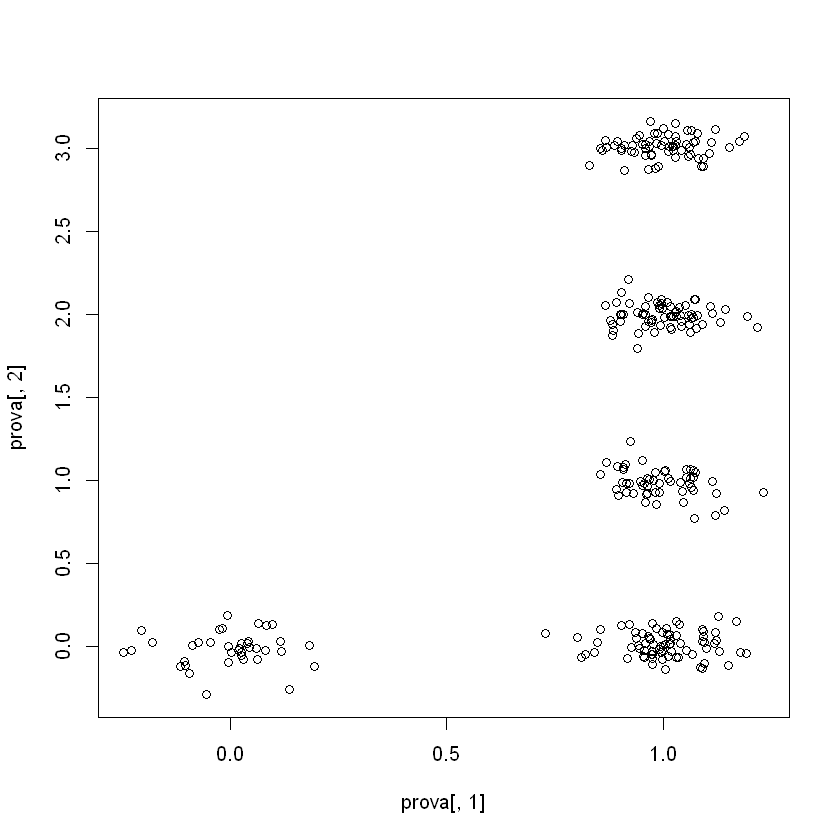

In [129]:
plot(prova[, 1], prova[, 2])

In [140]:
find_best_k(prova, 1000, method = "svd")

[1] 3

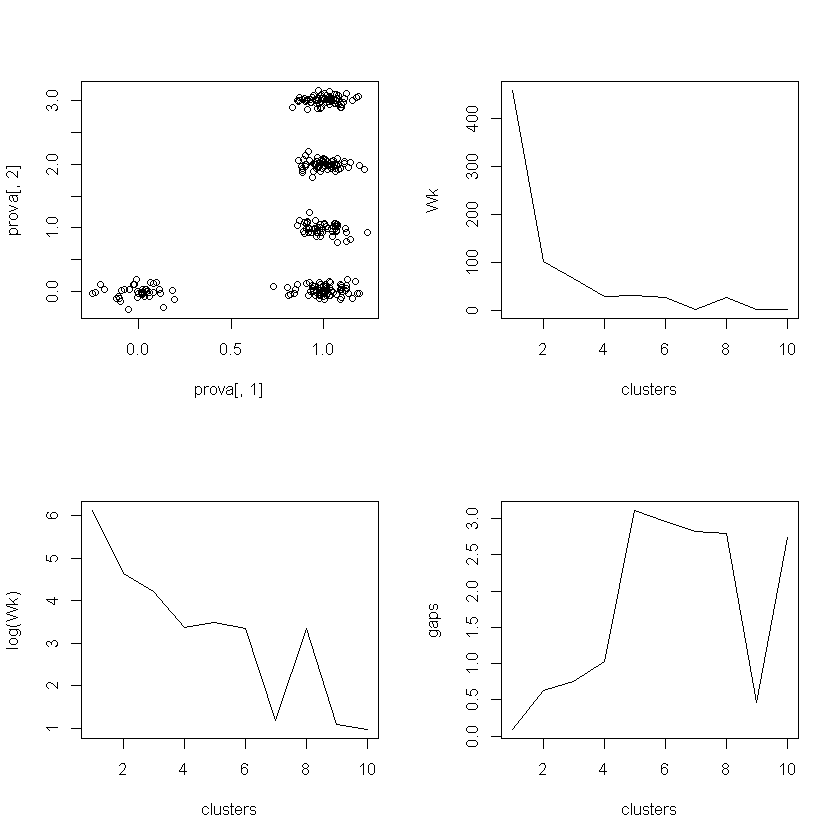

In [141]:
par(mfrow = c(2, 2))
plot(prova[, 1], prova[, 2])

clusters = 1 : 10
Wk = c()
for(cluster in clusters) {
    clustering = kmeans(prova, cluster, iter.max = 25)
    Wk = c(Wk, clustering$tot.withinss)
}
plot(clusters, Wk, type = "l")
plot(clusters, log(Wk), type = "l")

gaps = c()
for (cluster in clusters) {
    gaps = c(gaps, compute_gap_statistic(prova, cluster, 1000))
}
plot(clusters, gaps, type = "l")

In [120]:
Wk

[1] 1261.354220  375.285264  212.609913  109.963759  108.509533  112.844386
 [7]    9.604621    8.673026    7.542029    7.832566